In [1]:
from pathlib import Path
from typing import Callable, Optional, Tuple, Dict, List
import pandas as pd
import numpy as np 
import PIL
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disables the decompression bomb check
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torchvision import tv_tensors
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
import json
import os

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary
from torch.optim import SGD


import sys
sys.path.append('/dss/dsshome1/0A/di38tac/DOTA-Net/code')
from utils.dataset import DOTA_DATASET_v2, plot_image_with_boxes
from utils.training import train, validate

In [12]:
DOTA_SET = 'dota' # possible values: dota-subset, dota
SPLIT = 'train' # possible values: train, val, test-dev

DATA_ROOT = Path('/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/')
DOTA_ROOT = DATA_ROOT / DOTA_SET

META_FILE = DOTA_ROOT / 'meta.json'
LABELS_DIR = DOTA_ROOT / SPLIT / 'ann'
IMGS_DIR = DOTA_ROOT / SPLIT / 'img'
CSV_DIR = Path(f'/dss/dsshome1/0A/di38tac/DOTA-Net/Data/csv-files/{DOTA_SET}')
csv_file = DOTA_ROOT / f'{SPLIT}_split.csv'

In [13]:
## check boxes_string
df = pd.read_csv(csv_file)
labels = df.iloc[:,1].astype(str)
print("Size of Dataset =",len(df))


Size of Dataset = 1830


## Preprocess all images to be of size 1024x1024
To make datahandling easier and to speed up the training process, all pictures are preprocessed to the same size.

## Dataset class with integrated moving window
In this Dataset class DOTA_DATASET_v2, all images are taken and cropped in a moving window approach to the size 1024X1024.

torch.Size([3, 1024, 1024])
BoundingBoxes([[1014,  887, 1024,  938],
               [ 987,  890, 1024,  955],
               [ 963,  900, 1010,  964],
               ...,
               [ 815,  275,  830,  295],
               [ 807,  272,  817,  292],
               [ 227,  182,  302,  439]], format=BoundingBoxFormat.XYXY, canvas_size=(1024, 1024))
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        

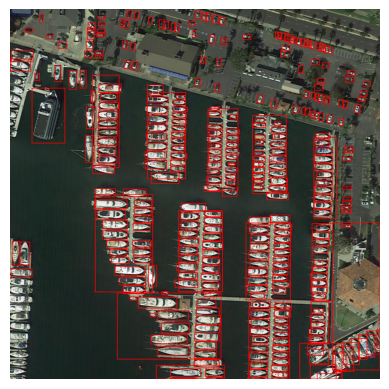

In [14]:
dataset = DOTA_DATASET_v2(csv_file=csv_file, root_img_dir=IMGS_DIR, tile_size=1024, overlap=200)
image, target = dataset[2]  # Get the first tile
print(image.shape)  # Should be (3, 1024, 1024)
print(target["boxes"])  # Bounding boxes adjusted for the tile

plot_image_with_boxes(image, target['boxes'])

+++Batch size: 4+++
---Inspecting sample 1 of batch 1---


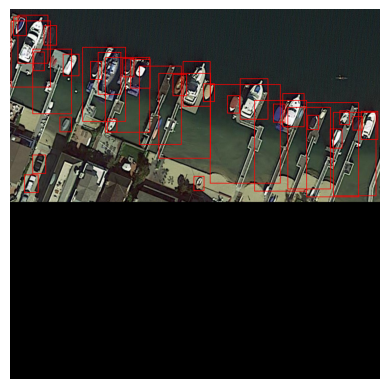

---Inspecting sample 2 of batch 1---


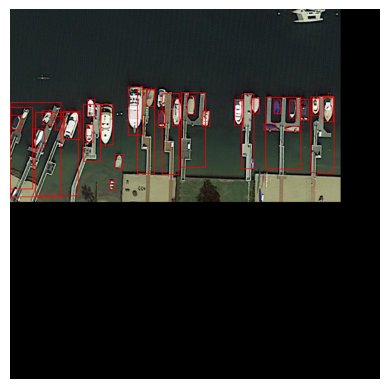

---Inspecting sample 3 of batch 1---


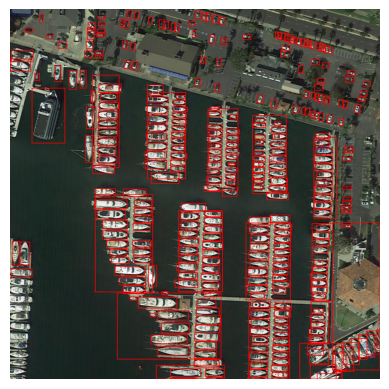

---Inspecting sample 4 of batch 1---


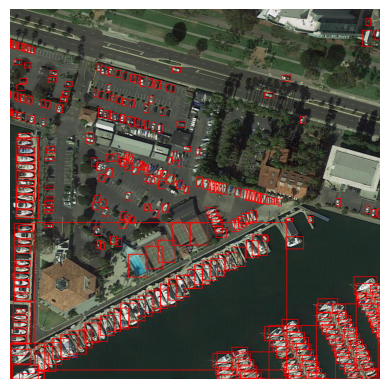

+++Batch size: 4+++
---Inspecting sample 1 of batch 2---


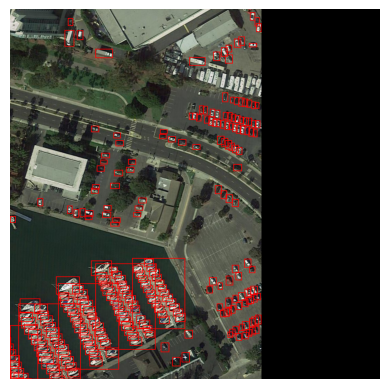

---Inspecting sample 2 of batch 2---


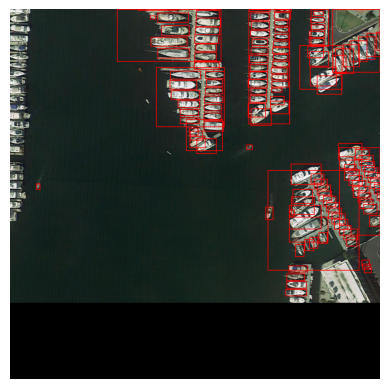

---Inspecting sample 3 of batch 2---


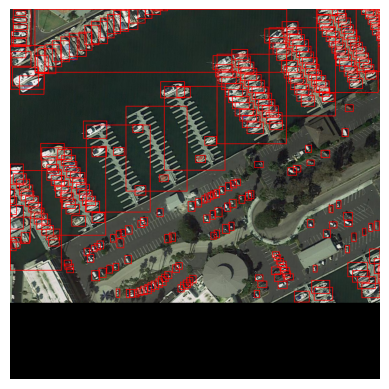

---Inspecting sample 4 of batch 2---


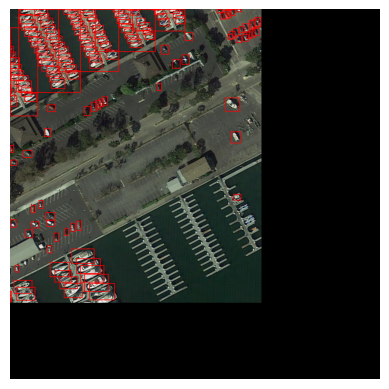

In [15]:
def collate_fn(batch: List[Tuple[Tensor, Dict[str, Tensor]]]) -> Tuple[List[Tensor], List[Dict[str, Tensor]]]:
    """
    Custom collate function to correctly batch the provided tensors by the dataset.

    Parameters
    ----------
    batch : List[Tuple[Tensor, Dict[str, Tensor]]]
        A list of tuples where each tuple contains an image tensor and its corresponding target dictionary.

    Returns
    -------
    Tuple[List[Tensor], List[Dict[str, Tensor]]]
        A tuple containing two lists - one for images and one for target dictionaries.
    """
    return tuple(zip(*batch))
    
data_loader = DataLoader(
    dataset,
    batch_size=4,
    collate_fn=collate_fn,
)

for i, (images, targets) in enumerate(data_loader):
    if i == 2: # n batches
        break
    print(f"+++Batch size: {len(images)}+++")
    for j, (img, target) in enumerate(zip(images, targets)):
        print(f"---Inspecting sample {j + 1} of batch {i + 1}---")
        plot_image_with_boxes(
        img, target['boxes'])
